In [ ]:
# pip install underthesea

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from joblib import dump
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")



In [13]:
drive.mount('/drive')
path = '/drive/MyDrive/ColabNotebooks/Data/Data_train.xlsx'
outputPath = '/drive/MyDrive/ColabNotebooks/Data/'

df = pd.read_excel(path)

print(df);

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
                                                  WORDS  Label
0     1. Bạn đã từng được tham gia vào công tác tổ c...      0
1                                          1. Họ và tên      0
2                                          1. Họ và tên      0
3                                          1. Họ và tên      0
4                                          1. Họ và tên      0
...                                                 ...    ...
2273                        Xác nhận tham gia hoạt động      1
2274                       Xác nhận tham gia hoạt động?      1
2275                                  Xác nhận vào nhóm      1
2276                                           Xếp loại      1
2277                                               zalo      0

[2278 rows x 2 columns]


In [15]:
count_label = df['Label'].value_counts().reset_index().sort_values(by=['Label'], ascending=True).reset_index()
total = 2278
number = 2000

print(count_label)

ratio = []
result = []

for i in range(0,10):
  numberOfLabel = count_label['count'][i]
  ratio.append(round((numberOfLabel/total)*100, 2))

  print(f"{count_label['Label'][i]}: {ratio[i]}")

  result.append( count_label['count'][i] + round((ratio[i]/100)*number))

print(result)



   index  Label  count
0      0      0   1135
1      1      1    363
2      8      2     32
3      9      3     10
4      5      4    124
5      4      5    137
6      6      6     70
7      2      7    191
8      3      8    160
9      7      9     56
0: 49.82
1: 15.94
2: 1.4
3: 0.44
4: 5.44
5: 6.01
6: 3.07
7: 8.38
8: 7.02
9: 2.46
[2131, 682, 60, 19, 233, 257, 131, 359, 300, 105]


In [ ]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=7000)
tfidf_vect_ngram.fit(df['WORDS'])

tranforms_tfidf_data = tfidf_vect_ngram.transform(df['WORDS'])
dump(tfidf_vect_ngram, outputPath + 'tfidf_vect_ngram.pkl')


k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
## Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

train_rf_scores = []
val_rf_scores = []
val_rf_precision = []
val_rf_recall = []
val_rf_f1score = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = tranforms_tfidf_data[train_index], tranforms_tfidf_data[val_index]
  y_train, y_val = df['Label'][train_index], df['Label'][val_index]
  rf.fit(X_train, y_train)

  train_pred = rf.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_rf_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = rf.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_rf_scores.append(val_accuracy)
  val_rf_precision.append(precision_score(y_val, val_pred, average='micro'))
  val_rf_recall.append(recall_score(y_val, val_pred, average='micro'))
  val_rf_f1score.append(f1_score(y_val, val_pred, average='micro'))

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = rf


print("Train scores:", train_rf_scores)
print("Train precision:", val_rf_precision)
print("Train recall:", val_rf_recall)
print("Train f1 score:", val_rf_f1score)
print("Mean train accuracy:", sum(train_rf_scores) / len(train_rf_scores))
print("Validation scores:", val_rf_scores)
print("Mean validation accuracy:", sum(val_rf_scores) / len(val_rf_scores))
print(f"Max accuracy: {max_accuracy}")
dump(rf, outputPath + 'RandomForest.pkl')

plt.plot(np.arange(1, 11), train_rf_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_rf_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Random Forest')
plt.xticks(np.arange(1, 6))
plt.legend()
plt.show()

In [ ]:
## Naive Bayes

nb_classifier = MultinomialNB()

tranforms_tfidf_data_dense = tranforms_tfidf_data.toarray()

train_nb_scores = []
val_nb_scores = []
val_nb_precision = []
val_nb_recall = []
val_nb_f1score = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = tranforms_tfidf_data_dense[train_index], tranforms_tfidf_data_dense[val_index]
  y_train, y_val = df['Label'][train_index], df['Label'][val_index]

  nb_classifier.fit(X_train, y_train)

  train_pred = nb_classifier.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_nb_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = nb_classifier.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_nb_scores.append(val_accuracy)
  val_nb_precision.append(precision_score(y_val, val_pred, average='micro'))
  val_nb_recall.append(recall_score(y_val, val_pred, average='micro'))
  val_nb_f1score.append(f1_score(y_val, val_pred, average='micro'))

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = nb_classifier

print("Train scores:", train_nb_scores)
print("Mean train accuracy:", sum(train_nb_scores) / len(train_nb_scores))
print("Validation scores:", val_nb_scores)
print("Mean validation accuracy:", sum(val_nb_scores) / len(val_nb_scores))
print(f"Max accuracy {max_accuracy}")
dump(nb_classifier, outputPath + 'NaiveBayes.pkl')


plt.plot(np.arange(1, 11), train_nb_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_nb_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Naive Bayes')
plt.xticks(np.arange(1, 6))
plt.legend()
plt.show()

In [ ]:
## Suppor Vector Machine

svm_classifier = SVC(kernel='linear', random_state=42)

train_svm_scores = []
val_svm_scores = []
val_svm_precision = []
val_svm_recall = []
val_svm_f1score = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = tranforms_tfidf_data[train_index], tranforms_tfidf_data[val_index]
  y_train, y_val = df['Label'][train_index], df['Label'][val_index]

  svm_classifier.fit(X_train, y_train)

  train_pred = svm_classifier.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_svm_scores.append(train_accuracy)


  # Calculate accuracy on the validation set
  val_pred = svm_classifier.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_svm_scores.append(val_accuracy)
  val_svm_precision.append(precision_score(y_val, val_pred, average='micro'))
  val_svm_recall.append(recall_score(y_val, val_pred, average='micro'))
  val_svm_f1score.append(f1_score(y_val, val_pred, average='micro'))

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = svm_classifier

print("Train scores:", train_svm_scores)
print("Mean train accuracy:", sum(train_svm_scores) / len(train_svm_scores))
print("Validation scores:", val_svm_scores)
print("Mean validation accuracy:", sum(val_svm_scores) / len(val_svm_scores))

print(f"Max accuracy {max_accuracy}")
dump(svm_classifier, outputPath + 'SVM.pkl')

plt.plot(np.arange(1, 11), train_svm_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_svm_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Support Vector Machine')
plt.xticks(np.arange(1, 6))
plt.legend()
plt.show()

In [ ]:
# plt.plot(np.arange(1, 11), train_rf_scores, label='Train Accuracy', marker='o')
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 11), val_svm_scores, label='SVM Validation Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_nb_scores, label='NB Validation Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_rf_scores, label='RF Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy of SVM, NB, RF with TF-IDF')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.show()

In [ ]:
# plt.plot(np.arange(1, 11), train_rf_scores, label='Train Accuracy', marker='o')
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 11), val_svm_f1score, label='SVM Validation F1 Score', marker='o')
plt.plot(np.arange(1, 11), val_nb_f1score, label='NB Validation F1 Score', marker='o')
plt.plot(np.arange(1, 11), val_rf_f1score, label='RF Validation F1 Score', marker='o')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score of SVM, NB, RF with TF-IDF')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.show()

# PhoBert

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import cross_val_score

import torch
from torch.utils.data import Dataset, DataLoader


# Define the dataset class using PhoBERT tokenizer
class PhoBertDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['WORDS']
        label = self.df.iloc[idx]['Label']
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize PhoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")

# Create the PhoBERT dataset
dataset = PhoBertDataset(df, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Function to get embeddings from PhoBERT
def get_embeddings(dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            label = batch['labels']
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_states = output.last_hidden_state[:, 0, :]
            embeddings.append(last_hidden_states.cpu().numpy())
            labels.append(label.cpu().numpy())
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# Get embeddings
embeddings, labels = get_embeddings(dataloader)

print(embeddings)
print(labels)




config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

[[ 0.50010985  0.30106592 -0.6919314  ... -0.11401685 -0.54183185
  -0.19626194]
 [ 0.04838809  0.36361548 -0.89216274 ... -0.3014235   0.14689757
  -0.6457601 ]
 [-0.26991278  0.51159114 -0.622353   ... -0.4090799   0.10661147
   0.29974294]
 ...
 [-0.22640917  0.2947369  -0.43937668 ...  0.51698494 -0.06492519
  -0.56127435]
 [-0.07271395  0.22418818 -0.7910465  ...  0.40439335  0.33690214
  -0.19199006]
 [-0.294896    0.45546517 -0.8145087  ...  0.29150733 -0.2331181
   0.05488105]]
[6 0 1 ... 1 0 9]


Train scores: [0.9759887005649718, 0.976, 0.976, 0.976, 0.9774117647058823, 0.9755294117647059, 0.9750588235294118, 0.9764705882352941, 0.976, 0.9788235294117648]
Mean train accuracy: 0.976328281821203
Validation scores: [0.8945147679324894, 0.8516949152542372, 0.902542372881356, 0.8177966101694916, 0.8432203389830508, 0.8771186440677966, 0.8601694915254238, 0.8686440677966102, 0.8771186440677966, 0.8305084745762712]
Mean validation accuracy: 0.8623328327254522
Max accuracy: 0.902542372881356


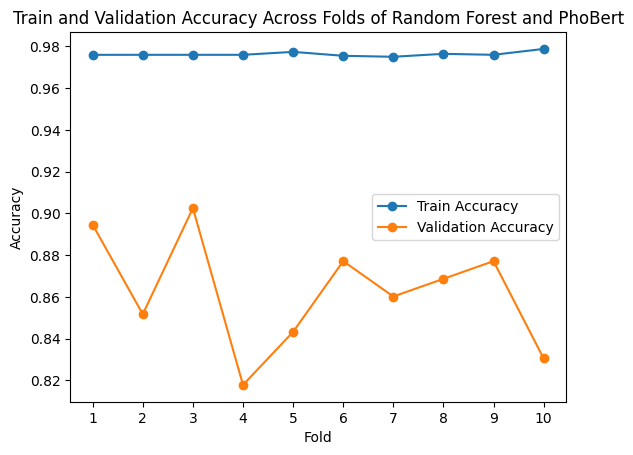

In [ ]:

# Train Random Forest with K-Fold cross-validation
rf_withPhoBert = RandomForestClassifier(n_estimators=100, random_state=42)

train_rf_pb_scores = []
val_rf_pb_scores = []
val_rf_pb_precision = []
val_rf_pb_recall = []
val_rf_pb_f1score = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = embeddings[train_index], embeddings[val_index]
  y_train, y_val = labels[train_index], labels[val_index]
  rf_withPhoBert.fit(X_train, y_train)

  train_pred = rf_withPhoBert.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_rf_pb_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = rf_withPhoBert.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_rf_pb_scores.append(val_accuracy)
  val_rf_pb_precision.append(precision_score(y_val, val_pred, average='micro'))
  val_rf_pb_recall.append(recall_score(y_val, val_pred, average='micro'))
  val_rf_pb_f1score.append(f1_score(y_val, val_pred, average='micro'))

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = rf_withPhoBert

# # Print out the mean cross-validation score
# print(f"Mean CV Score: {np.mean(cv_scores)}")

print("Train scores:", train_rf_pb_scores)
print("Mean train accuracy:", sum(train_rf_pb_scores) / len(train_rf_pb_scores))
print("Validation scores:", val_rf_pb_scores)
print("Mean validation accuracy:", sum(val_rf_pb_scores) / len(val_rf_pb_scores))
print(f"Max accuracy: {max_accuracy}")
dump(max_accuracy_model, outputPath + 'RandomForestWithPhoBert.pkl')

plt.plot(np.arange(1, 11), train_rf_pb_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_rf_pb_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of Random Forest and PhoBert')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.show()


Train scores: [0.7066854990583804, 0.712, 0.6974117647058824, 0.6785882352941176, 0.7021176470588235, 0.6927058823529412, 0.7011764705882353, 0.6945882352941176, 0.6941176470588235, 0.7143529411764706]
Mean train accuracy: 0.6993744322587793
Validation scores: [0.70042194092827, 0.6567796610169492, 0.7288135593220338, 0.673728813559322, 0.6652542372881356, 0.673728813559322, 0.7033898305084746, 0.6567796610169492, 0.6271186440677966, 0.6440677966101694]
Mean validation accuracy: 0.6730082957877423
Max accuracy: 0.7288135593220338


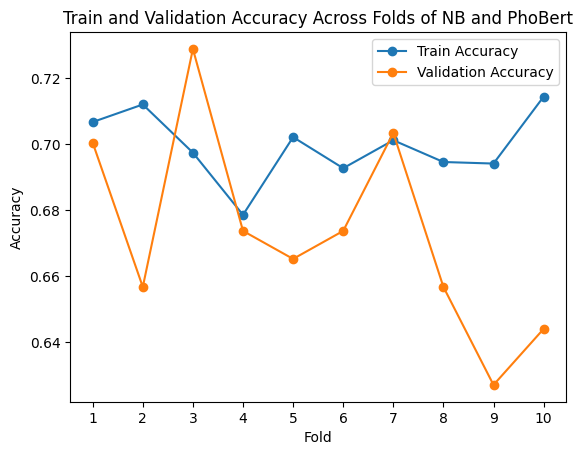

In [ ]:
## Naive Bayes
from sklearn.preprocessing import MinMaxScaler

nb_classifier = MultinomialNB()

train_nb_pb_scores = []
val_nb_pb_scores = []
val_nb_pb_precision = []
val_nb_pb_recall = []
val_nb_pb_f1score = []

max_accuracy = 0
max_accuracy_model = None

# print(np.min(embeddings))
# print(np.max(embeddings))

# scaler = MinMaxScaler(feature_range=(np.min(embeddings), np.max(embeddings)))
scaler = MinMaxScaler()

scale_data = scaler.fit_transform(embeddings)

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = scale_data[train_index], scale_data[val_index]
  y_train, y_val = labels[train_index], labels[val_index]
  nb_classifier.fit(X_train, y_train)

  train_pred = nb_classifier.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_nb_pb_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = nb_classifier.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_nb_pb_scores.append(val_accuracy)
  val_nb_pb_precision.append(precision_score(y_val, val_pred, average='micro'))
  val_nb_pb_recall.append(recall_score(y_val, val_pred, average='micro'))
  val_nb_pb_f1score.append(f1_score(y_val, val_pred, average='micro'))

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = nb_classifier

# # Print out the mean cross-validation score
# print(f"Mean CV Score: {np.mean(cv_scores)}")

print("Train scores:", train_nb_pb_scores)
print("Mean train accuracy:", sum(train_nb_pb_scores) / len(train_nb_pb_scores))
print("Validation scores:", val_nb_pb_scores)
print("Mean validation accuracy:", sum(val_nb_pb_scores) / len(val_nb_pb_scores))
print(f"Max accuracy: {max_accuracy}")
dump(max_accuracy_model, outputPath + 'NaiveBayesWithPhoBert.pkl')

plt.plot(np.arange(1, 11), train_nb_pb_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_nb_pb_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of NB and PhoBert')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.show()


Train scores: [0.9759887005649718, 0.976, 0.976, 0.976, 0.9774117647058823, 0.9755294117647059, 0.9750588235294118, 0.9764705882352941, 0.976, 0.9788235294117648]
Mean train accuracy: 0.976328281821203
Validation scores: [0.9113924050632911, 0.8813559322033898, 0.9110169491525424, 0.8940677966101694, 0.8686440677966102, 0.9067796610169492, 0.9194915254237288, 0.902542372881356, 0.8771186440677966, 0.8898305084745762]
Mean validation accuracy: 0.8962239862690409
Max accuracy: 0.9194915254237288


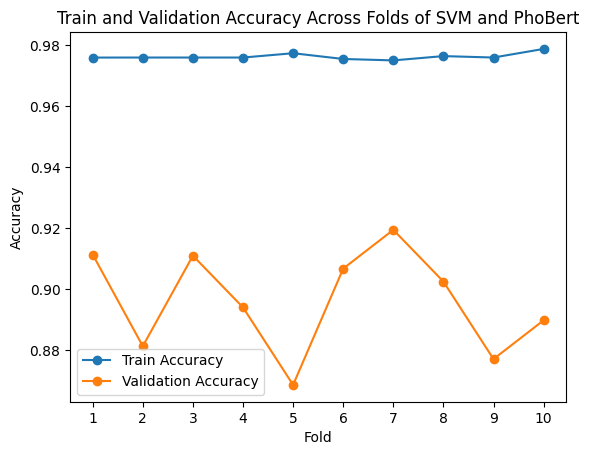

In [ ]:
## SVM

svm_classifier = SVC(kernel='linear', random_state=42)

train_svm_pb_scores = []
val_svm_pb_scores = []
val_svm_pb_precision = []
val_svm_pb_recall = []
val_svm_pb_f1score = []

max_accuracy = 0
max_accuracy_model = None

for train_index, val_index in k_fold.split(df['WORDS']):
  X_train, X_val = embeddings[train_index], embeddings[val_index]
  y_train, y_val = labels[train_index], labels[val_index]
  svm_classifier.fit(X_train, y_train)

  train_pred = svm_classifier.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)
  train_svm_pb_scores.append(train_accuracy)

  # Calculate accuracy on the validation set
  val_pred = svm_classifier.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)
  val_svm_pb_scores.append(val_accuracy)
  val_svm_pb_precision.append(precision_score(y_val, val_pred, average='micro'))
  val_svm_pb_recall.append(recall_score(y_val, val_pred, average='micro'))
  val_svm_pb_f1score.append(f1_score(y_val, val_pred, average='micro'))

  if val_accuracy > max_accuracy:
    max_accuracy = val_accuracy
    max_accuracy_model = svm_classifier

# # Print out the mean cross-validation score
# print(f"Mean CV Score: {np.mean(cv_scores)}")

print("Train scores:", train_svm_pb_scores)
print("Mean train accuracy:", sum(train_svm_pb_scores) / len(train_svm_pb_scores))
print("Validation scores:", val_svm_pb_scores)
print("Mean validation accuracy:", sum(val_svm_pb_scores) / len(val_svm_pb_scores))
print(f"Max accuracy: {max_accuracy}")
dump(max_accuracy_model, outputPath + 'SVMWithPhoBert.pkl')

plt.plot(np.arange(1, 11), train_svm_pb_scores, label='Train Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_svm_pb_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Across Folds of SVM and PhoBert')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.show()


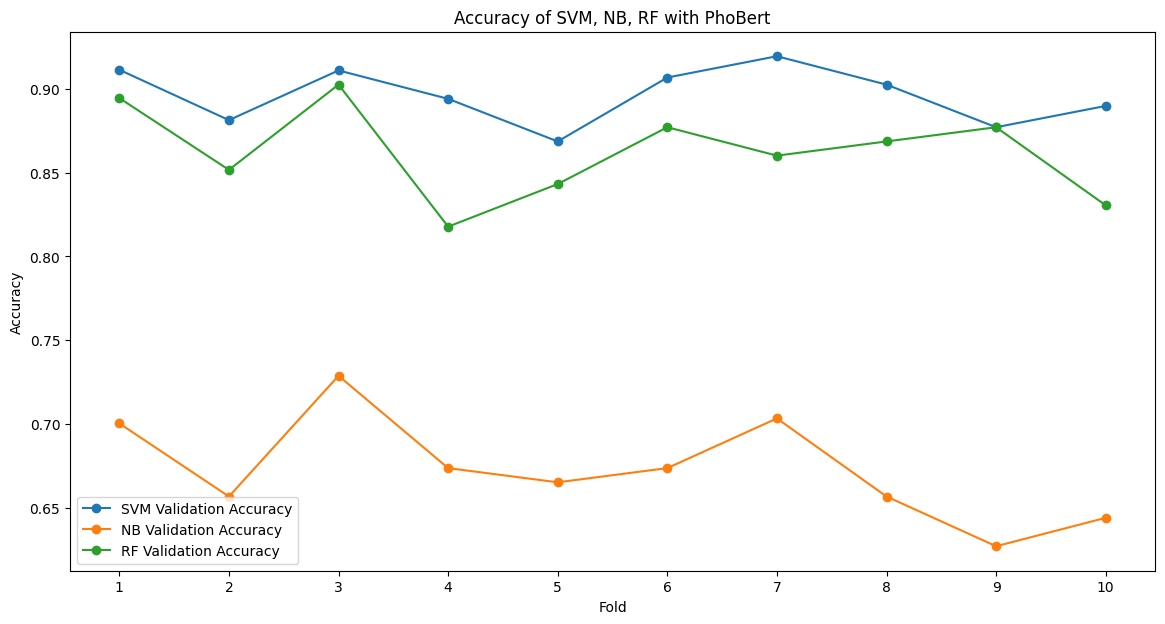

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 11), val_svm_pb_scores, label='SVM Validation Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_nb_pb_scores, label='NB Validation Accuracy', marker='o')
plt.plot(np.arange(1, 11), val_rf_pb_scores, label='RF Validation Accuracy', marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy of SVM, NB, RF with PhoBert')
plt.xticks(np.arange(1, 11))
plt.legend()
plt.show()

In [ ]:
print("With TF-IDF")
print(f"Random Forest: & {round(sum(val_rf_scores)/10, 2)} & {round(sum(val_rf_precision)/10, 2)} & {round(sum(val_rf_recall)/10, 2)} & {round(sum(val_rf_f1score)/10, 2)}")
print(f"SVM: & {round(sum(val_svm_scores)/10, 2)} & {round(sum(val_svm_precision)/10, 2)} & {round(sum(val_svm_recall)/10, 2)} & {round(sum(val_svm_f1score)/10, 2)}")
print(f"NB: & {round(sum(val_nb_scores)/10, 2)} & {round(sum(val_nb_precision)/10, 2)} & {round(sum(val_nb_recall)/10, 2)} & {round(sum(val_nb_f1score)/10, 2)}")
print("RF:")
print(val_rf_scores)

print("SVM:")
print(val_svm_scores)

print("NB:")
print(val_nb_scores)



print("\n\nWith PhoBert")
print(f"Random Forest: & {round(sum(val_rf_pb_scores)/10, 2)} & {round(sum(val_rf_pb_precision)/10, 2)} & {round(sum(val_rf_pb_recall)/10, 2)} & {round(sum(val_rf_pb_f1score)/10, 2)}")
print(f"SVM: & {round(sum(val_svm_pb_scores)/10, 2)} & {round(sum(val_svm_pb_precision)/10, 2)} & {round(sum(val_svm_pb_recall)/10, 2)} & {round(sum(val_svm_pb_f1score)/10, 2)}")
print(f"SVM: & {round(sum(val_nb_pb_scores)/10, 2)} & {round(sum(val_nb_pb_precision)/10, 2)} & {round(sum(val_nb_pb_recall)/10, 2)} & {round(sum(val_nb_pb_f1score)/10, 2)}")
print(val_svm_pb_scores)

With TF-IDF
Random Forest: & 0.85 & 0.85 & 0.85 & 0.85
SVM: & 0.84 & 0.84 & 0.84 & 0.84
NB: & 0.8 & 0.8 & 0.8 & 0.8
RF:
[0.8523206751054853, 0.8728813559322034, 0.7923728813559322, 0.809322033898305, 0.8940677966101694, 0.864406779661017, 0.8347457627118644, 0.8516949152542372, 0.885593220338983, 0.8432203389830508]
SVM:
[0.8354430379746836, 0.864406779661017, 0.7966101694915254, 0.809322033898305, 0.885593220338983, 0.8686440677966102, 0.809322033898305, 0.8389830508474576, 0.8516949152542372, 0.8347457627118644]
NB:
[0.8270042194092827, 0.8432203389830508, 0.809322033898305, 0.7754237288135594, 0.8177966101694916, 0.8559322033898306, 0.7542372881355932, 0.7838983050847458, 0.8050847457627118, 0.7627118644067796]


With PhoBert
Random Forest: & 0.86 & 0.86 & 0.86 & 0.86
SVM: & 0.9 & 0.9 & 0.9 & 0.9
SVM: & 0.67 & 0.67 & 0.67 & 0.67
[0.9113924050632911, 0.8813559322033898, 0.9110169491525424, 0.8940677966101694, 0.8686440677966102, 0.9067796610169492, 0.9194915254237288, 0.9025423728813